# Predictor Training

In [1]:
import os
import numpy as np
import pandas as pd
import pickle
import imp
import json
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import seaborn as sns
#from tqdm.auto import tqdm
from tqdm import tqdm
import torch
import glob
from datetime import datetime
import cv2 as cv


from Prediction import dataset
from Prediction import train_eval
from Prediction import predictor
from Prediction import visualize
from Prediction import detector
from Prediction import dataset
from Prediction import kalman_predict
from Prediction import seq2seq_predict
from Prediction import calibration as calib

## Imp reload

In [250]:
imp.reload(dataset)
imp.reload(train_eval)
imp.reload(seq2seq_predict)
imp.reload(predictor)
imp.reload(visualize)
imp.reload(detector)
imp.reload(dataset)
imp.reload(kalman_predict)

<module 'Prediction.kalman_predict' from '/app/Pogona_realtime/Arena/Prediction/kalman_predict.py'>

## Initialize YOLOv4 detector

In [3]:
det = detector.Detector_v4()

Detector initiated successfully


## Load Data

In [3]:
all_df = dataset.collect_data(data_sources={'detections': True, 'timestamps': True, 'dlc': False, 'touches': True})

46 trials loaded


(-507.76554708950636,
 2273.8644900137674,
 -395.23839888336073,
 3862.7752047072668)

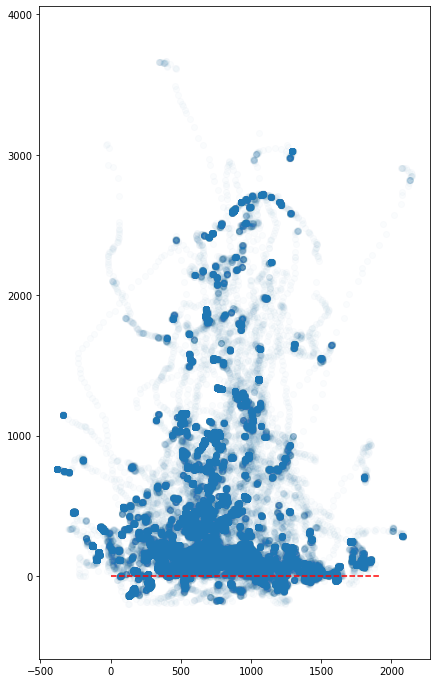

In [4]:
plt.figure(figsize=(7,12))
plt.scatter(all_df.x2,all_df.y2,alpha=0.02)
plt.plot(np.linspace(0,1920,num=10),np.zeros(10),color='r',linestyle='--')
plt.axis('equal')

In [5]:
feeding_mask = all_df.index.str.contains('feeding')

In [6]:
all_df[feeding_mask].shape

(54008, 16)

In [7]:
feeding_df = all_df[feeding_mask]

## Train Seq2Seq Trajectory Predictor

In [8]:
# all trials (experiments + feeding)
all_trials = list(all_df.index.unique())
all_trials = list(filter(lambda trial: not all(all_df.loc[trial].x2.isna()),all_trials))

In [11]:
# only feeding trials
all_trials = list(feeding_df.index.unique())
all_trials = list(filter(lambda trial: not all(feeding_df.loc[trial].x2.isna()),all_trials))

In [9]:
results=[]
train, val, test = train_eval.create_train_val_test_splits(all_trials, [0.8, 0.2, 0])

In [346]:
train, val, test

(['feeding_4_20200830-125905_None',
  'line_20200803T114942_trial1',
  'beetle_fast_line_20200830T124020_trial1',
  'line_20200803T101641_trial2',
  'circle_20200803T115839_trial1',
  'line_20200803T081735_trial1',
  'feeding_4_screen_20200830-130446_None',
  'circle_20200803T093051_trial1',
  'cockroach_line_20200830T120130_trial1',
  'circle_20200803T084227_trial2',
  'circle_20200803T091639_trial1',
  'circle_20200803T090615_trial1',
  'worm_line_20200830T121513_trial1',
  'line_20200803T101641_trial1',
  'worm_line_20200830T122932_trial1',
  'cockroach_circle_20200830T123508_trial1',
  'circle_20200803T084227_trial1',
  'line_20200803T094928_trial1',
  'feeding_4_20200830-122515_None',
  'feeding_20200830-115520_None',
  'circle_20200803T084529_trial1',
  'line_20200803T095401_trial1',
  'circle_20200803T113121_trial1',
  'feeding_20200830-120813_None',
  'fast_cockroach_20200803T085738_trial1',
  'worm_line_20200830T120451_trial1',
  'worm_circle_20200830T122241_trial1',
  'worm_2

### Network parameters

In [10]:
input_labels = ['x1', 'y1', 'x2', 'y2']
output_labels = ['x1', 'y1', 'x2', 'y2']
input_dim = len(input_labels)
output_dim = len(output_labels)

inp_seq_len = 20
out_seq_len = 20
embedding_size = 4  # only used in supporting models.
hidden_size = 350
rnn_layers = 1
dropout = 0.05

batch_size = 256

In [347]:
# Create dataloader for training
train_dl, val_dl, test_dl = train_eval.create_train_val_test_dataloaders(
    all_df, train, val, test, input_labels, output_labels, inp_seq_len, 
    out_seq_len, batch_size=batch_size, std_threshold=5, keep_lowvar_prob=0.2)

f"number of training samples: {len(train_dl) * batch_size}"

'number of training samples: 106496'

### Choose a seq2seq Model

In [818]:
"""
Network hyperparameters:
- in GRU and LSTM:
    - number of layers
    - hidden state dimension
    - embedding layer for the input
    - input and output length

Training parameters:
    - loss
    - type of optimizer
    - learning rate, schedueler
    - gradient clipping
    - batch size (does it matter?)
    - dropout
    - normalization/ standardization (?)
    - weight regularization (?) https://machinelearningmastery.com/use-weight-regularization-lstm-networks-time-series-forecasting/


Data statistics:

"""

'\nNetwork hyperparameters:\n- in GRU and LSTM:\n    - number of layers\n    - hidden state dimension\n    - embedding layer for the input\n    - input and output length\n\nTraining parameters:\n    - loss\n    - type of optimizer\n    - learning rate, schedueler\n    - gradient clipping\n    - batch size (does it matter?)\n    - dropout\n    - normalization/ standardization (?)\n    - weight regularization (?) https://machinelearningmastery.com/use-weight-regularization-lstm-networks-time-series-forecasting/\n\n\nData statistics:\n\n'

Problem:

With current data the models are not able to learn or generalize. The initial random weights 
score is not much than the test score achieved after several epochs. Also, the loss reaches saturation very fast
and the testing metric (ADE, FDE) only increase or reach saturation very fast.

- Models: tried 2 architechtures, LSTM-Dense and GRU-Enc-Dec, with various parameters.

- Training parameters: tried various training parameters. Could be that some specific configuration will lead to better result, but very hard to systematicly search for these parameters.

- Data: training with a single trial led to "normal" learning dynamics, which might indicate that there's no problem with the model. But still the model can't learn the entire dataset, and it's unclear what property of the dataset causes this. Maybe a different composition of sequences, or a larger and more consistent dataset would have worked. It's still unclear how and if more data will help. In the worst case, the data is just unlearnable for certain forecast horizons.

Possible things to try:

- New models and architechtures. 

- Add the cropped head image as extra input, with a part in the archtichture processing the image.

- More systematic hyperparameter and training parameters search.

- Other data pereperations, filtering, more data, etc.

In [591]:
imp.reload(dataset)
imp.reload(train_eval)
imp.reload(seq2seq_predict)
imp.reload(predictor)
imp.reload(visualize)
imp.reload(detector)
imp.reload(dataset)
imp.reload(kalman_predict)

<module 'Prediction.kalman_predict' from '/app/Pogona_realtime/Arena/Prediction/kalman_predict.py'>

In [132]:
model_type = 'LSTMdense'
net = seq2seq_predict.LSTMdense(out_seq_len, hidden_size=hidden_size, 
                     embedding_size=embedding_size, LSTM_layers=rnn_layers, dropout=dropout)

In [20]:
model_type = 'GRUEncDec'
net = seq2seq_predict.GRUEncDec(output_seq_size=out_seq_len, hidden_size=hidden_size, GRU_layers=rnn_layers,
                     tie_enc_dec=False, use_gru_cell=True, dropout=dropout)

In [173]:
model_type = 'GRUPositionEncDec'
net = seq2seq_predict.GRUPositionEncDec(output_seq_size=out_seq_len, hidden_size=hidden_size, embedding_size=embedding_size,
                             GRU_layers=rnn_layers, dropout=dropout)

In [1]:
model_type = 'VelLinear'
net = seq2seq_predict.VelLinear(input_size=input_dim, output_size=output_dim, input_seq_size=inp_seq_len, output_seq_size=out_seq_len, 
                     hidden_size=hidden_size, dropout=dropout)

NameError: name 'seq2seq_predict' is not defined

### Train

In [600]:
date = datetime.now().strftime('%m%d-%H%M')
model_name=f"{model_type}_{date}_i{inp_seq_len}_o{out_seq_len}_h{hidden_size}_b{batch_size}_l{rnn_layers}"

clip_grad_norm = 1.5
lr = 0.00005
epochs = 50
eval_freq = 5
epoch_print_freq = 5
save_each_eval_model = False
loss_fn = train_eval.calc_ADE
#loss_fn = train_eval.angle_norm_displacement_loss_fn([1,1])
best_epoch, best_ADE, losses, ADEs, FDEs = train_eval.train_trajectory_model(model=net, 
                                                                             train_dataloader=train_dl,
                                                                             test_dataloader=val_dl,
                                                                             epochs=epochs,
                                                                             path='Prediction/traj_models/',
                                                                             clip_grad_norm=clip_grad_norm,
                                                                             eval_freq=eval_freq,
                                                                             loss_fn=loss_fn,
                                                                             epoch_print_freq=epoch_print_freq,
                                                                             model_name=model_name,
                                                                             save_each_eval_model=save_each_eval_model,
                                                                             lr=lr)

results.append((losses, ADEs, FDEs, f"{model_type} h{hidden_size} i{inp_seq_len} o{out_seq_len} lr{lr}"))

### Eval epoch: 0, Test set mean ADE: 80.178, mean FDE: 156.999
Epoch: 0, avg loss: 35.189, epoch time: 5.527
### Eval epoch: 5, Test set mean ADE: 22.879, mean FDE: 38.677
Epoch: 5, avg loss: 24.125, epoch time: 5.494
### Eval epoch: 10, Test set mean ADE: 22.286, mean FDE: 38.007
Epoch: 10, avg loss: 23.612, epoch time: 5.614
### Eval epoch: 15, Test set mean ADE: 22.142, mean FDE: 37.876
Epoch: 15, avg loss: 23.184, epoch time: 5.598
### Eval epoch: 20, Test set mean ADE: 22.170, mean FDE: 38.057
Epoch: 20, avg loss: 22.747, epoch time: 5.662
### Eval epoch: 25, Test set mean ADE: 22.209, mean FDE: 38.258
Epoch: 25, avg loss: 22.265, epoch time: 5.585
### Eval epoch: 30, Test set mean ADE: 22.325, mean FDE: 38.487
Epoch: 30, avg loss: 21.829, epoch time: 5.626
### Eval epoch: 35, Test set mean ADE: 22.612, mean FDE: 39.240
Epoch: 35, avg loss: 21.415, epoch time: 5.514


KeyboardInterrupt: 

### Display results

In [49]:
results = pickle.load(open("Prediction/traj_models/overfit-3ksamps-results.p", "rb"))

In [100]:
pickle.dump(results, open(f"Prediction/traj_models/GRU_&LSTM_metrics_{date}.p", 'wb'))

In [17]:
def plot_train_results(results_list, title):
    fig, axs = plt.subplots(3, figsize=(10,20))
    fig.suptitle(title)

    axs[0].set_ylabel("ADE")
    axs[1].set_ylabel("FDE")
    axs[2].set_ylabel("loss")
    
    for (losses, ADEs, FDEs, name) in results_list:
        if 'LSTM' in name:
            lstyle = '--'
        else:
            lstyle = '-'
        axs[0].plot(list(ADEs.values()), label=name, linestyle=lstyle)
        #axs[0].legend()
        axs[1].plot(list(FDEs.values()), label=name, linestyle=lstyle)
        #axs[1].legend()
        #axs[0].set_xticklabels(np.ar)
        axs[2].plot(losses, label=name, linestyle=lstyle)
        axs[2].legend()        

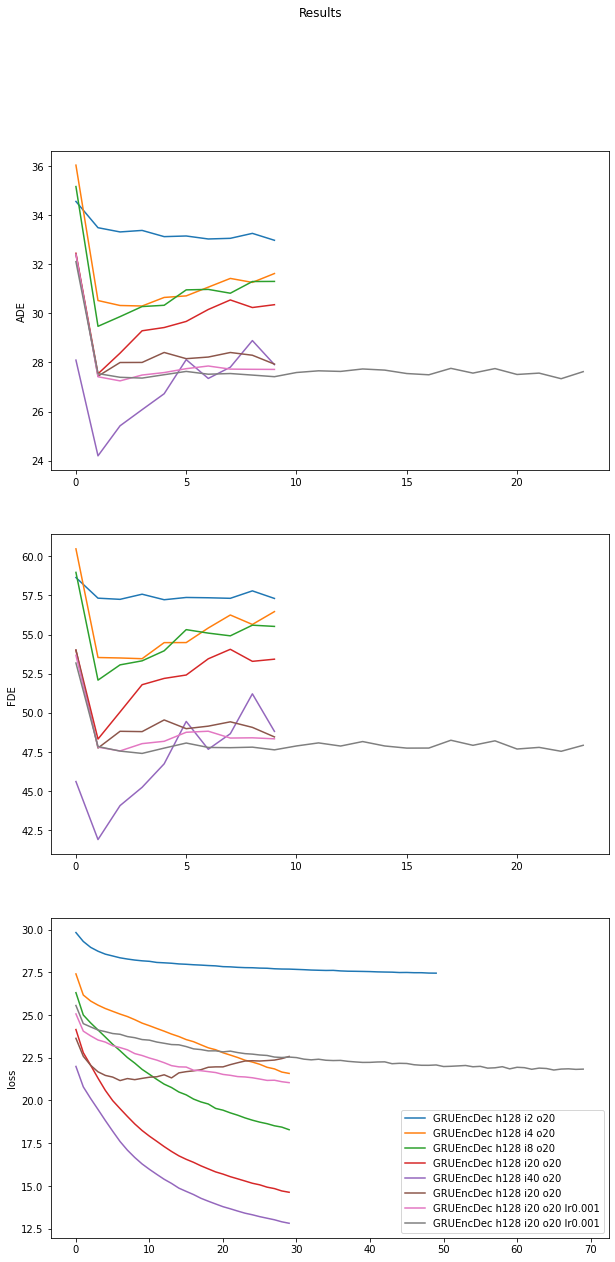

In [60]:
plot_train_results(results, "Results")

### AX Hyperparameter tuning

In [3]:
# https://ax.dev/tutorials/tune_cnn.html
import torch
import numpy as np

from ax.plot.contour import plot_contour
from ax.plot.trace import optimization_trace_single_method
from ax.service.managed_loop import optimize
from ax.utils.notebook.plotting import render, init_notebook_plotting
from ax.utils.tutorials.cnn_utils import load_mnist, train, evaluate, CNN

init_notebook_plotting()


In [59]:
HP_JSON = 'Prediction/traj_models/0_models_hps.json'

def update_hp_json(model_name, model_params_dict):
    if os.path.exists(HP_JSON):
        with open(HP_JSON, 'r') as fp:
            json_dict = json.load(fp)
    else:
        json_dict = dict()
        
    json_dict[model_name] = model_params_dict
    
    with open(HP_JSON, 'w') as fp:
        json.dump(json_dict, fp)


In [96]:
inp_seq_len = 20
out_seq_len = 20
embedding_size = None  # only used in supporting models.
#hidden_size = 128
#rnn_layers = 1

In [103]:
def train_evaluate(params):
    print(params)
    
    date = datetime.now().strftime('%m%d-%H%M%S')
    model_type = 'GRUEncDec'
    
    epochs = 100
    eval_freq = 5
    epoch_print_freq = 10000
    save_each_eval_model = False    
    
    rnn_layers = 1
    
    hidden_size = params['hidden_size']
    #rnn_layers = params['rnn_layers']
    dropout = params['dropout']
    clip_grad_norm = params['clip_grad_norm']
    lr = params['lr']
    
    model_name=f"{model_type}_{date}_i{inp_seq_len}_o{out_seq_len}_b{batch_size}"    
    net = seq2seq_predict.GRUEncDec(output_seq_size=out_seq_len,
                                hidden_size=hidden_size, 
                                GRU_layers=rnn_layers,
                                tie_enc_dec=False, 
                                use_gru_cell=True, 
                                dropout=dropout)

    best_epoch, best_ADE, losses, ADEs, FDEs = train_eval.train_trajectory_model(model=net, 
                                                                                 train_dataloader=train_dl,
                                                                                 test_dataloader=val_dl,
                                                                                 epochs=epochs,
                                                                                 path='Prediction/traj_models/',
                                                                                 clip_grad_norm=clip_grad_norm,
                                                                                 eval_freq=eval_freq,
                                                                                 epoch_print_freq=epoch_print_freq,
                                                                                 model_name=model_name,
                                                                                 save_each_eval_model=save_each_eval_model,
                                                                                 lr=lr)
    params['best_epoch'] = best_epoch
    params['best_ADE'] = best_ADE
    params['best_ADE_epoch_loss'] = losses[best_epoch]
    params['rnn_layers'] = rnn_layers
    
    update_hp_json(model_name, params)
    
    return best_ADE

def train_evaluate2(params):
    return np.random.normal()

In [104]:
parameters=[
    {"name": "lr", "type": "range", "bounds": [0.00001, 0.01], "log_scale": True},
    {"name": "hidden_size", "type": "range", "bounds": [32, 384]},
    {"name": "dropout", "type": "range", "bounds": [0.0, 0.75]},
    #{"name": "rnn_layers", "type": "range", "bounds": [1, 3]},
    {"name": "clip_grad_norm", "type": "range", "bounds": [0.5, 10.0]}
    ]


In [ ]:
best_parameters, values, experiment, model = optimize(
    parameters=parameters,
    evaluation_function=train_evaluate,
    objective_name='ADE',
    total_trials=50, 
    minimize=True)

[INFO 09-15 19:56:21] ax.modelbridge.dispatch_utils: Using Bayesian Optimization generation strategy: GenerationStrategy(name='Sobol+GPEI', steps=[Sobol for 5 trials, GPEI for subsequent trials]). Iterations after 5 will take longer to generate due to  model-fitting.
[INFO 09-15 19:56:21] ax.service.managed_loop: Started full optimization with 50 steps.
[INFO 09-15 19:56:21] ax.service.managed_loop: Running optimization trial 1...


{'lr': 4.37555406410694e-05, 'hidden_size': 382, 'dropout': 0.4775395926553756, 'clip_grad_norm': 1.6149856802076101}
### Eval epoch: 0, Test set mean ADE: 33.967, mean FDE: 56.638
Epoch: 1, avg loss: 25.699, epoch time: 9.716
### Eval epoch: 5, Test set mean ADE: 27.196, mean FDE: 47.054
### Eval epoch: 10, Test set mean ADE: 26.863, mean FDE: 46.844
### Eval epoch: 15, Test set mean ADE: 26.725, mean FDE: 46.581
### Eval epoch: 20, Test set mean ADE: 26.655, mean FDE: 46.544
### Eval epoch: 25, Test set mean ADE: 26.641, mean FDE: 46.559
### Eval epoch: 30, Test set mean ADE: 26.552, mean FDE: 46.312


In [106]:
values

({'ADE': 26.06375928337079}, {'ADE': {'ADE': 9.524271687552747e-09}})

In [107]:
best_parameters

{'lr': 6.591781359510046e-05,
 'hidden_size': 350,
 'dropout': 9.133681056711136e-05,
 'clip_grad_norm': 1.343065509441185}

#### Ax Results

- values = ({'ADE': 26.06375928337079}, {'ADE': {'ADE': 9.524271687552747e-09}})
- best_parameters = {'lr': 6.591781359510046e-05,
 'hidden_size': 350,
 'dropout': 9.133681056711136e-05,
 'clip_grad_norm': 1.343065509441185}